In [1]:
from helpers.utilities import (
    create_paths, DataFrame, Series, partial, read_csv, read_table,
    T, F, np, pd
)
%run helpers/notebook_setup.ipynb

In [2]:
%R source('plots/colors.R');

In [3]:
__inputs__ = create_paths(path='data/integration/', csv=['patients_with_both'])
clinical_path = 'data/clean/clinical/data_with_derived_variables.csv'

In [4]:
patients_with_both = Series.from_csv(__inputs__['patients_with_both'])

In [5]:
joint_cm_and_tmd = patients_with_both[patients_with_both.str.contains('TMD|CM')]
joint_cm_and_tmdr = patients_with_both[patients_with_both.str.contains('TMR|TMD|CM')]

In [6]:
clinical = read_csv(clinical_path, index_col=0)

In [7]:
clinical.loc[patients_with_both].Meningitis_with_tuberculosis_status.value_counts()

Cryptococcal             14
Definite tuberculosis     7
Viral                     7
Possible tuberculosis     4
Probable tuberculosis     4
Name: Meningitis_with_tuberculosis_status, dtype: int64

## 0. Normalization and pre-processing pipeline

In [8]:
raw_protein_path = 'data/clean/protein/gene_levels_by_entrez.csv'
raw_rna_path = 'data/clean/rna/all_samples_counts.csv'

In [9]:
raw_protein_matrix = read_csv(raw_protein_path, index_col=0)
raw_rna_matrix = read_csv(raw_rna_path, index_col=0)

id_to_symbol_df = read_table('data/hgnc/entrez_ids_to_gene_symbol.tsv', index_col=3)
id_to_symbol = id_to_symbol_df[id_to_symbol_df.Status == 'Approved']['Approved symbol'].to_dict()

raw_protein_matrix.index = list(
    Series(raw_protein_matrix.index).apply(lambda x: id_to_symbol.get(x, x))
)

from helpers.ensembl import Ensembl

ensembl = Ensembl(95)

ensembl_to_gene_name = ensembl.merge_gene_data(raw_rna_matrix)[['gene_name']]

rna_ensembl_index = raw_rna_matrix.index
rna_gene_index = raw_rna_matrix.index.map(lambda x: ensembl_to_gene_name['gene_name'].get(x, x))


# use this one for transposed (profiles) integration
# TODO: potentialy, I could reject some isoforms which are not translated or otherwise malfucioning
#       for such analyses
rna_matrix_isoforms_collapsed = raw_rna_matrix.copy()
rna_matrix_isoforms_collapsed.index = rna_gene_index
rna_matrix_isoforms_collapsed = rna_matrix_isoforms_collapsed.groupby(rna_gene_index).sum()

raw_rna_matrix.index = np.where(
    # if gene symbol is duplicated
    rna_gene_index.duplicated(keep=F),
    # then append the ensembl id:
    rna_gene_index + ' (' + rna_ensembl_index + ')',
    # otherwise just use the gene symbol:
    rna_gene_index
)

In [10]:
patients_union = set(raw_rna_matrix.columns | raw_protein_matrix.columns)
patients_union_series = Series(list(patients_union))

full_cm_and_tmdr = patients_union_series[patients_union_series.str.contains('TMR|TMD|CM')]

In [11]:
joint_cm_and_tmdr.map(clinical.Meningitis).value_counts()

Cryptococcal    14
Tuberculosis    11
dtype: int64

The proteins mapped to gene levels were sometimes annotated to two genes as two genes can encode the same (or very similar) protein:

In [12]:
raw_protein_matrix.duplicated().any()

True

In [13]:
raw_protein_matrix[raw_protein_matrix.duplicated(keep=False)]

,149.TMD,007.TMD,001.TMD,064.TMD,151.TMD,...,177.HC,189.HC,217.HC,221.HC,245.HC
IGHA1,101109.00,74983.45,87520.25,89105.75,66557.85,...,7778.70,4196.10,29164.80,11745.00,21501.35
IGHA2,101109.00,74983.45,87520.25,89105.75,66557.85,...,7778.70,4196.10,29164.80,11745.00,21501.35
CSH1,282.35,1317.50,266.15,423.45,385.70,...,67.65,51.80,65.30,78.85,123.85
CSH2,282.35,1317.50,266.15,423.45,385.70,...,67.65,51.80,65.30,78.85,123.85
HIST1H3C,2449.50,7755.82,1385.12,6004.69,1624.96,...,21.64,2.67,7.98,4.16,10.28
...,...,...,...,...,...,...,...,...,...,...,...
ITGB3,36.55,137.10,26.30,78.70,20.15,...,9.65,10.45,9.60,10.05,15.00
SUMO3,14126.10,24300.50,11457.45,14932.60,7584.35,...,734.55,538.70,637.10,966.00,3338.75
SUMO2,14126.10,24300.50,11457.45,14932.60,7584.35,...,734.55,538.70,637.10,966.00,3338.75
LGALS7,121.75,276.75,70.80,171.00,73.80,...,21.25,24.45,974.30,25.95,65.95


To enable the use of methods which prohibit exact collinearity I remove the exact duplicates, however retaining the information of alternative gene mappings for future pathway analysis and interpretation; I also keep a copy with all of the genes for the use in gene-gene regression:

In [14]:
raw_protein_matrix_with_duplicates = raw_protein_matrix.copy()

In [15]:
gene_hashes = raw_protein_matrix.apply(
    lambda gene: hash(gene.values.data.tobytes()),
    axis=1
)

In [16]:
assert all(gene_hashes.duplicated() == raw_protein_matrix.duplicated())

In [17]:
collapsed_genes = (
    raw_protein_matrix
    .rename_axis('gene')
    .reset_index()
    .groupby(gene_hashes.values)
    .gene.transform(lambda x: ', '.join(list(x.astype('str'))))
)

In [18]:
raw_protein_matrix.index = collapsed_genes
raw_protein_matrix = raw_protein_matrix.drop_duplicates()

In [19]:
raw_protein_matrix.shape

(1271, 82)

Remember to strip the ensembl id off for the pathways analysis!

In [20]:
clinical = clinical.loc[patients_union]

In [21]:
protein_conditions = clinical.loc[raw_protein_matrix.columns].Meningitis
protein_conditions.value_counts()

Tuberculosis       26
Healthy control    25
Cryptococcal       24
Viral               7
Name: Meningitis, dtype: int64

In [22]:
rna_conditions = clinical.loc[raw_rna_matrix.columns].Meningitis
rna_conditions.value_counts()

Tuberculosis    28
Cryptococcal    18
Viral            8
Bacterial        2
Name: Meningitis, dtype: int64

Note: the group assignments are not used for the the normalization, but the quantities of the groups are used for the filtering step (the number of samples in the smallest group).

As explained in [Differential_expression.ipynb notebook](/analyses/rnaseq_vs_clinical/Differential_expression.ipynb) (*Gene filtering* part), I mask the smallest group for RNA data (bacterial) as it is not used in analyses anyway.

In [23]:
rna_conditions_masked = rna_conditions.replace('Bacterial', 'Tuberculosis')

In [24]:
%%R -i raw_protein_matrix -i raw_rna_matrix -i rna_matrix_isoforms_collapsed -i rna_conditions_masked -i protein_conditions
import::here(normalize_abundance, .from='helpers/preprocessing.R')
import::here(remove_leading_X, .from = 'helpers/utilities.R')
import::here(normalize_abundance, choose_regions_above_the_mean, choose_all_regions, .from='helpers/preprocessing.R')


colnames(raw_rna_matrix) = remove_leading_X(colnames(raw_rna_matrix))
colnames(rna_matrix_isoforms_collapsed) = remove_leading_X(colnames(rna_matrix_isoforms_collapsed))
colnames(raw_protein_matrix) = remove_leading_X(colnames(raw_protein_matrix))


trend_correction_presets = list(
    loess_local=list(
        blind=F,
        choose_regions_to_correct=choose_regions_above_the_mean
    ),
    loess_global=list(
        choose_regions_to_correct=choose_all_regions,
        blind=F
    ),
    loess_global_relative=list(
        choose_regions_to_correct=choose_all_regions,
        blind=F,
        shirink_relative_to_diff=T
    ),
    non_blind=list(blind=T),
    blind=list(blind=F)
)


normalize = function(what, subset=NULL, outliers='warn', collapse_rna_isoforms=FALSE, trend_preset=NULL, ...) {
    if (what == 'both')
        return(c(
            normalize('rna', subset, outliers, collapse_rna_isoforms, trend_preset, ...),
            normalize('protein', subset, outliers, collapse_rna_isoforms, trend_preset, ...)
        ))
    matrix = switch(
        what,
        rna=(
            if(collapse_rna_isoforms)
                rna_matrix_isoforms_collapsed
            else
                raw_rna_matrix
        ),
        protein=raw_protein_matrix
    )

    conditions_vector = switch(
        what,
        rna=rna_conditions_masked,
        protein=protein_conditions
    )

    if (!is.null(outliers)) {
        if (outliers == 'warn') {
            print('Not removing any outliers')
        }
        else {
            is_outlier = colnames(matrix) %in% outliers
            print(paste('Removing', sum(is_outlier), 'outliers'))

            matrix = matrix[,!is_outlier, drop=FALSE]
            conditions_vector = conditions_vector[!is_outlier]
        }
    }
    if (!is.null(subset)) {
        matrix = matrix[,subset, drop=FALSE]
        conditions_vector = conditions_vector[subset]
    }
    
    if(!is.null(trend_preset))
        trend_args = trend_correction_presets[[trend_preset]]
    else
        trend_args = list()

    normalize_abundance(matrix, conditions_vector, trend_args=trend_args, ...)
}

In [25]:
from helpers.r import r_function

normalize = partial(r_function, 'normalize')

In [26]:
_pa = normalize('protein', subset=joint_cm_and_tmdr, normalization_method='TMM')

[1] "Not removing any outliers"
[1] "Retaining: 99.61%"


### 0.1 Outliers

Unsupervised analysis identified outliers in RNA data. I exclude those: 

In [27]:
RNA_OUTLIERS = [
    '175.TMD', '074.TMS', '093.TMD', '128.TMD',
    '158.TMD', '167.TMR', '233.CM'
]

In [28]:
_ra = normalize(
    'rna', subset=joint_cm_and_tmdr, outliers=RNA_OUTLIERS,
    normalization_method='TMM'
)

[1] "Removing 7 outliers"
[1] "Retaining: 34.65%"


In [29]:
_ra_collapsed_isoforms = normalize(
    'rna', subset=joint_cm_and_tmdr, outliers=RNA_OUTLIERS,
    normalization_method='TMM', collapse_rna_isoforms=True
)

[1] "Removing 7 outliers"
[1] "Retaining: 35.58%"


### 0.2 Additional filtering

In [30]:
from machine_learning.preprocessing import LowCountsFilter, LowVarianceFilter, RSideNormalizer

While pre-filtering is done in the normalize_abundance function in R (using edgeR's `edgeR::filterByExpr` function), this is done prior to normalization. This may not enough because:
- prior to the normalization we can only remove the near zero-counts (for RNA-Seq) or very low intensities (for SOMAScan)as otherwise our thresholds would be affected by the library sizes for RNA data.
- addition of median based filtering matches the workflow of SIMCA, which is the standard commercial tool for O2PLS

I reject the variables with too many counts being equal to the median to be of practical interest, using threshold of 33.3% (SIMCA uses threshold of 2).

I demonstrate the extend of the filtering below, using TMM-normalized data:

In [31]:
filter_out_low_count = partial(LowCountsFilter().fit_transform, y=None)

Low count (or "often not too different from median") does not filter out anything:

In [32]:
_raf_isoforms = filter_out_low_count(_ra_collapsed_isoforms)

LowCountsFilter: filtering out 0/0 variables


In [33]:
_raf = filter_out_low_count(_ra)

LowCountsFilter: filtering out 0/0 variables


Proteins were measured by microarrays, thus identical values will be rare:

In [34]:
_paf = filter_out_low_count(_pa)

LowCountsFilter: filtering out 0/0 variables


Therefore, I additionally filter out the observations with very low variance (below 0.1 percentile):

In [35]:
filter_out_very_low_variance = partial(LowVarianceFilter().fit_transform, y=None)

In [36]:
_raf = filter_out_very_low_variance(_raf)

LowVarianceFilter: filtering out 1/1 variables


In [37]:
_paf = filter_out_very_low_variance(_paf)

LowVarianceFilter: filtering out 1/1 variables


In [38]:
common_genes = list(_raf_isoforms.index.intersection(_paf.index))

In [39]:
len(common_genes)

941

### 0.3 OmicsPLS

NIPALS is referred to as "alternative" or "power" method; to use it one should set `p_thresh=1` (so that it is lower than number of features in X) or do an analogous thing with q_thresh. I will use NIPALS as it is much faster implementation (7min vs 1s)

In [40]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from helpers.pls import format_grid_results
from helpers.o2pls import O2PLS, O2PLSStatistic
from helpers.o2pls import add_grid_metadata, summary_table_for
%R source('thirdparty/OmicsPLS_overrides.R');


Attaching package: ‘OmicsPLS’

The following object is masked from ‘package:stats’:

    loadings



Note: different rules for CV are used in SIMCA, as explained in "Multi- and Megavariate Data Analysis" Appendix II: Statistics, page 462 (Third revised edition). For predictive components threshold of Q2 > 0.01 is required (among other rules), for orthogonal components PCA rules apply.

A set of statistics will be computed during cross validation for every model:

In [41]:
cv_scoring = {
    name: statistic.calc
    for name, statistic in O2PLSStatistic.statistics.items()
}

In [42]:
%%R
import::here(
    grid_search_plot, grid_orthogonal_components_plot,
    .from='plots/omics_o2pls.R'
)

## 1. Logistic LASSO, using all data

(Logistic regression with L1 regularization)

First, a model using all the patients TMD, TMR and CM patients was trained in order to elucidate the potential biomarkers proteins with maximal power. 

Next, in order to exactly match the train-test split used in O2-PLS (due to limited number of samples) only the patients with data for both omics are used for training and patients with data for a single omic are used for validation.

In [43]:
from sklearn.linear_model import LogisticRegressionCV

In [44]:
%R import::here(plot_roc_auc, plot_coefficients, .from='plots/machine_learning.R')
from machine_learning.repeated_cv import (
    null_distributions_over_cv, repeated_cross_validation
)

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Loading required package: ROCR
Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

Loading required package: data.table
 
cvAUC version: 1.1.0
Notice to cvAUC users: Major speed improvements in version 1.1.0
 


In [45]:
cross_validate_single_ratio = partial(
    repeated_cross_validation,
    response=clinical.Meningitis,
    case_class='Tuberculosis',
    use_seed=True,
    multi_scale=False,
    test_size_min=0.25,
    test_size_max=0.25,
    min_class_members=2
)

In [46]:
cross_validate = partial(
    repeated_cross_validation,
    response=clinical.Meningitis,
    case_class='Tuberculosis',
    use_seed=True,
    multi_scale=True,
    test_size_min=0.16,
    test_size_max=0.33,
    min_class_members=2
)

In [47]:
%%R
import::here(
    coefficients_volcano_plot, plots_most_frequently_included,
    plot_most_significant, plot_highest_magnitutude,
    plot_roc_auc, mean_vs_coefficients,
    .from='plots/machine_learning.R'
)

### 1.1 Proteins:

In [48]:
protein_conditions.value_counts()

Tuberculosis       26
Healthy control    25
Cryptococcal       24
Viral               7
Name: Meningitis, dtype: int64

In [49]:
min(protein_conditions.value_counts())

7

In [50]:
joint_cm_and_tmdr.str.split('.').str[1].value_counts()

CM     14
TMD     7
TMR     4
dtype: int64

In [51]:
from rpy2.robjects import NULL as Null
from machine_learning.multi_block_pipeline import predict_proba, TwoBlockPipeline
from machine_learning.utilities import df_keeping
from machine_learning.preprocessing import ConditionsVectorizer, OutliersFilter, PreFilterLowestExpresion
%R import::here(filter_out_low_expression_by_n, .from='helpers/preprocessing.R')
filter_out_low_expression_by_n = partial(r_function, 'filter_out_low_expression_by_n')


OMICS = {
    'rna': raw_rna_matrix,
    'protein': raw_protein_matrix
}


def preprocess(
    omic_name, smallest_group_n, outliers,
    subset=None, verbose=False, omics=OMICS,
    normalization_method='TMM', log=True, **kwargs
):

    omic_data = omics[omic_name]

    if subset is not None:
        omic_data = omic_data.loc[:, subset]

    return make_pipeline(
        OutliersFilter(outlier_patients=outliers, verbose=verbose),
        PreFilterLowestExpresion(
            func=filter_out_low_expression_by_n,
            data=omic_data,
            smallest_group_n=smallest_group_n,
            verbose=verbose
        ),
        RSideNormalizer(
            normalize,
            omic_name, normalization_method=normalization_method, log=log, filter=False,
            # including other experimental groups to enhance correction for the errors of instruments
            # thus subseting is not done in this variant
            # subset=subset,
            # outliers were remove prior to this pipeline execution to avert
            # the need of adjusting train/test split due to patients exclusion
            outliers=Null, **kwargs
        ),
        LowCountsFilter(verbose=verbose),
        LowVarianceFilter(verbose=verbose),
        df_keeping(StandardScaler)()
    )


def two_blocks_with_supervision(data_block: DataFrame, conditions_vector: Series):
    conditions = list(conditions_vector)
    conditions = Series(conditions, index=conditions)
    return [data_block, conditions.loc[data_block.index]]


def subset(omic, subset, outliers=None):
    df = omic[omic.columns.intersection(subset)].T
    if outliers is not None:
        of = OutliersFilter(outlier_patients=outliers, verbose=True)
        df = of.fit_transform(df)
    return df

Just for diagnostics, we transform the protein matrix here:

In [52]:
protein_full = preprocess('protein', 7, None).fit_transform(raw_protein_matrix.T)

[1] "Retaining: 99.92%"


In [53]:
def create_lasso_pipeline(omic, smallest_group_n, outliers, subset=None, verbose=False, **kwargs):

    return TwoBlockPipeline(
        x=preprocess(omic, smallest_group_n, outliers, verbose=verbose, **kwargs),
        y=make_pipeline(
            OutliersFilter(outlier_patients=outliers, verbose=verbose),
            ConditionsVectorizer(mapping=clinical.Meningitis, case_class='Tuberculosis')
        ),
        combine=LogisticRegressionCV(
            penalty='l1', solver='liblinear',
            class_weight='balanced',
            max_iter=150
        ),
        predict=predict_proba
    )

In [54]:
lasso_pipeline_protein = create_lasso_pipeline(
    'protein',
    smallest_group_n=7,
    subset=full_cm_and_tmdr,
    outliers=None,
    verbose=False
)

[1] "Retaining: 99.92%"


In [55]:
protein_lasso = cross_validate(
    lasso_pipeline_protein,
    two_blocks_with_supervision(
        subset(raw_protein_matrix, full_cm_and_tmdr),
        full_cm_and_tmdr
    ),
    n=100,
    stratify=T,
    early_normalization=True
)

In [56]:
protein_lasso.cross_validation_results.metrics.accuracy_score(round=True).mean()

0.9261567599067598

In [57]:
df = DataFrame(dict(
    cv_split_auc=protein_lasso.cross_validation_results.cv_auc,
    coefficients_count=protein_lasso.cross_validation.coefficients.x.non_zero_coeffs_count_by_cv
))

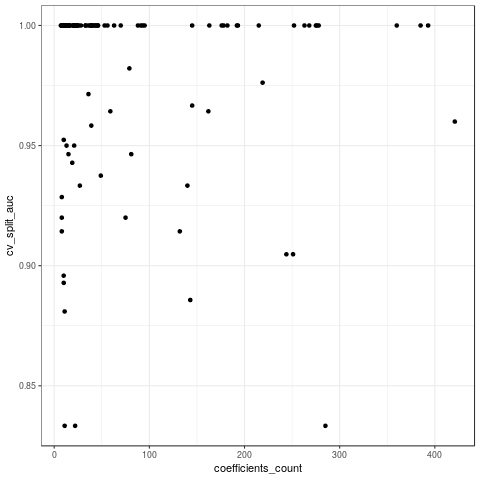

In [58]:
%%R -i df
(
    ggplot(df, aes(x=coefficients_count, y=cv_split_auc))
    + geom_point()
    + nice_theme
)

Many models have less than 50 coefficients; such models can achieve high scores anyway. Of course this is nested CV.

#### Coefficients co-selection network

In [59]:
network = protein_lasso.cross_validation.contributions.x.co_selection_network(
    contribution_threshold=0.01,
    selection_threshold=0.5
)

In [60]:
def format_selection_network(contra_network, contributions, key='log2_frequency_ratio'):
    cn = contra_network
    cn_labels = Series(list(set(cn.a) | set(cn.b))).reset_index().set_index(0)['index']
    cn['source'] = cn.a.map(cn_labels) + 1
    cn['destination'] = cn.b.map(cn_labels) + 1
    cn_contributions = contributions.data.loc[cn_labels.index]
    return cn, cn_contributions

In [61]:
cn, cn_contributions = format_selection_network(network, protein_lasso.cross_validation.contributions.x)

In [62]:
sanity_check = _pa.loc[list(set(cn.a) | set(cn.b))].T.assign(
    condition=lambda x: clinical.Meningitis.loc[x.index]
).groupby('condition').mean().T
sanity_check = DataFrame(dict(
    greater_mean_abundance=sanity_check.Tuberculosis > sanity_check.Cryptococcal,
    greater_mean_coeff=cn_contributions['mean'] > 0
))
assert all(sanity_check.greater_mean_abundance == sanity_check.greater_mean_coeff)

In [63]:
cn = cn[[*['source', 'destination'], *cn.columns.difference(['source', 'destination'])]]

Frequently co-selected pairs of proteins which contribute (on average) more than 5% of weight to the model:

In [64]:
cn.sort_values('weight')

,source,destination,a,b,count,frequency,log2_frequency_ratio,relative_weight,sign_agreement,weight
104,13,3,CXCL9,POMC,33,0.33,0.022470,10.293517,0,0.026049
134,4,10,FOLH1,"JCHAIN, IGHM",36,0.36,0.440916,24.781351,0,0.027753
137,13,10,CXCL9,"JCHAIN, IGHM",36,0.36,0.280451,2.469066,25,0.028375
85,13,4,CXCL9,FOLH1,26,0.26,-0.161019,9.680115,0,0.030916
101,4,3,FOLH1,POMC,33,0.33,0.182935,-4.048375,22,0.031746
...,...,...,...,...,...,...,...,...,...,...
71,14,9,MMP10,SLPI,83,0.83,-0.179549,-11.125795,0,0.193209
8,1,2,TNFSF8,CDH1,68,0.68,-0.282701,495.083979,0,0.193748
10,9,2,SLPI,CDH1,68,0.68,-0.377859,2.700402,65,0.195240
58,14,1,MMP10,TNFSF8,69,0.69,-0.350907,-2.517466,69,0.224746


TODO: clustering of coefficients with pvclust.

Loading required package: magrittr

Attaching package: ‘imager’

The following object is masked from ‘package:magrittr’:

    add

The following object is masked from ‘package:pROC’:

    ci

The following objects are masked from ‘package:stats’:

    convolve, spectrum

The following object is masked from ‘package:graphics’:

    frame

The following object is masked from ‘package:base’:

    save.image

network: Classes for Relational Data
Version 1.15 created on 2019-04-01.
copyright (c) 2005, Carter T. Butts, University of California-Irvine
                    Mark S. Handcock, University of California -- Los Angeles
                    David R. Hunter, Penn State University
                    Martina Morris, University of Washington
                    Skye Bender-deMoll, University of Washington
 For citation information, type citation("network").
 Type help("network-package") to get started.

Loading required package: sna
Loading required package: statnet.common

Attaching pack

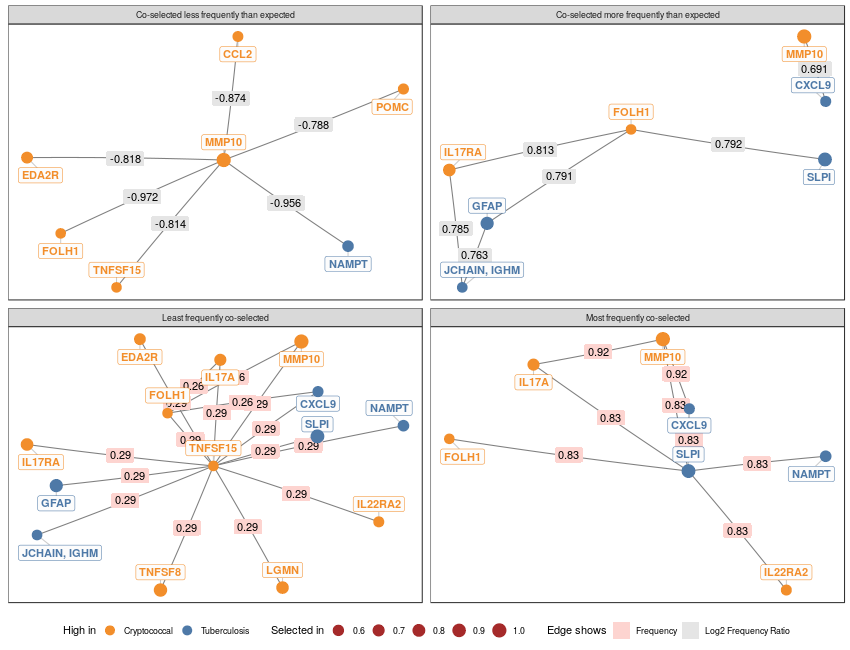

In [65]:
%%R -i cn -i cn_contributions -w 850 -h 650
import::here(plot_contributions_network, .from='plots/machine_learning.R')
import::here(optimize_space_usage, .from='plots/utils.R')
    
whites = optimize_space_usage(
    function(){
        plot_contributions_network(cn, cn_contributions, q=0.035)# + expand_limits(x = c(0.7, 0.8))
    },
    5
)
set.seed(which.max(whites))
p = plot_contributions_network(cn, cn_contributions, q=0.035)# + expand_limits(x = c(0.7, 0.8))
suppressMessages(ggsave('temp.png', p, dpi=80, w=10, h=7, scale=1.2))
p

The numbers on the lines indicate the average increase in contribution when the other gene was not included. If the protein from which the arrow starts is excluded, what is the increase in the importance of the protein to which the arrow points, relative to the importance of the excluded gene?

Correlations do not explain many of the co-selections:

In [66]:
from scipy.stats import spearmanr

In [67]:
spearmanr(_paf.loc['ITGA1, ITGB1'], _paf.loc['GFAP'])

SpearmanrResult(correlation=0.13043478260869562, pvalue=0.5435259752175851)

In [68]:
spearmanr(_paf.loc['MMP10'], _paf.loc['CXCL9'])

SpearmanrResult(correlation=-0.2652173913043478, pvalue=0.2103838978731484)

In [69]:
spearmanr(_paf.loc['MMP10'], _paf.loc['IL17A'])

SpearmanrResult(correlation=0.5199999999999999, pvalue=0.009197719807264302)

Nor of the cases when two proteins are not co-selected:

In [70]:
spearmanr(_paf.loc['ITGA1, ITGB1'], _paf.loc['CXCL9'])

SpearmanrResult(correlation=0.5095652173913043, pvalue=0.010975435304819026)

In [71]:
spearmanr(_paf.loc['ITGA1, ITGB1'], _paf.loc['IL17A'])

SpearmanrResult(correlation=-0.5104347826086956, pvalue=0.010817218599752949)

Moreover, this pair of proteins which is co-selected less frequently than expected has quite high correlation:

In [72]:
spearmanr(_paf.loc['TNFSF15'], _paf.loc['MMP10'])

SpearmanrResult(correlation=0.8208695652173912, pvalue=8.934346201224865e-07)

All of which warrants caution when interpreting this analysis.

TODO: overlay the predictions with DE heatmap, i.e. are there patients consistently misclassified and any special characteristic about them? 

In [73]:
protein_lasso.training_dataset.class_imbalance

0.45454545454545453

The class imbalance is moderate, thus I do not balance the CV splits futher; however, I still use weights proportional to the group cardinality in the regression model.

In [74]:
protein_lasso.cross_validation_results.metrics.accuracy_score(round=True).mean()

0.9261567599067598

#### Singificance

In [75]:
cv_null_tbm = partial(
    null_distributions_over_cv, response=clinical.Meningitis, case_class='Tuberculosis',
    multi_scale=True,
    stratify=T,
    test_size_min=0.16,
    test_size_max=0.33,
    min_class_members=2
)

In [76]:
protein_lasso_null_distributions = cv_null_tbm(
    lasso_pipeline_protein,
    two_blocks_with_supervision(
        subset(raw_protein_matrix, full_cm_and_tmdr),
        full_cm_and_tmdr
    ),
    block='x',
    n=100,
    permutations=100,
    early_normalization=True
)

In [77]:
protein_lasso.cross_validation.coefficients.x.add_permutation_significance(
    protein_lasso_null_distributions.cross_validation.coefficients,
    n=25, decrease_n_by=5
)
protein_lasso.cross_validation.contributions.x.add_permutation_significance(
    protein_lasso_null_distributions.cross_validation.contributions,
    n=25, decrease_n_by=5
)

/home/krassowski/.pyenv/versions/3.7.2/envs/meningitis/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2159: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/home/krassowski/.pyenv/versions/3.7.2/envs/meningitis/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/krassowski/.pyenv/versions/3.7.2/envs/meningitis/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/home/krassowski/meningitis/code/helpers/p_values.py:133: UserWarning: A good GPD fit could not be reached, using ECDF estimate instead
  warn(f'A good GPD fit could not be reached, using ECDF estimate instead')
/home/krassowski/.pyenv/versions/3.7.2/envs/meningitis/lib/python3.7/site-packages/skgof/ecdfgof.py:81: RuntimeWarning: divide by zero encountere

In [78]:
protein_coeffs = protein_lasso.cross_validation.coefficients.x.data
protein_contribs = protein_lasso.cross_validation.contributions.x.data

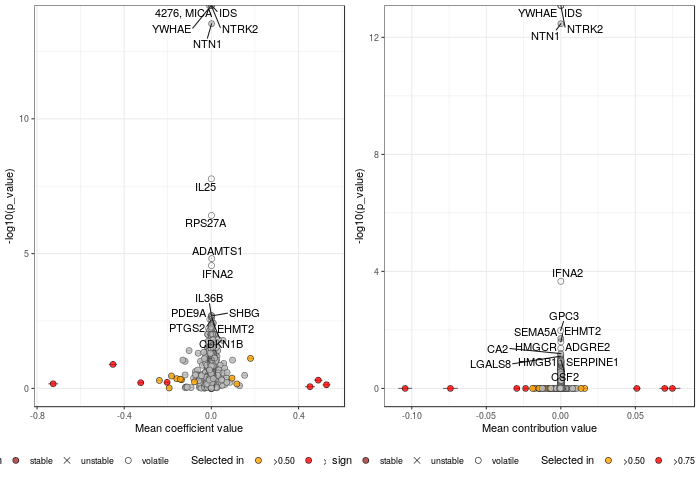

In [79]:
%%R -w 700 -i protein_coeffs -i protein_contribs
library(patchwork)
p1 = coefficients_volcano_plot(protein_coeffs, n=15) + ylab('Mean coefficient value')
p2 = coefficients_volcano_plot(protein_contribs, n=15) + ylab('Mean contribution value')
p1 + p2

**The permutation p-values obtained greatly differ from the initial results; I suspect that there might be an issue in the code...**

In [80]:
protein_lasso.cross_validation.contributions.x.add_hdi_significance(
    protein_lasso.training_dataset.x,
    protein_lasso.training_dataset.binary_response,
    family='binomial'
)

Loading required package: scalreg
Loading required package: lars
Loaded lars 1.2

Nodewise regressions will be computed as no argument Z was provided.
You can store Z to avoid the majority of the computation next time around.
Z only depends on the design matrix x.


In [81]:
protein_lasso.cross_validation.contributions.x.add_hdi_significance(
    protein_lasso.training_dataset.x,
    protein_lasso.training_dataset.binary_response,
    family='gaussian'
)

Nodewise regressions will be computed as no argument Z was provided.
You can store Z to avoid the majority of the computation next time around.
Z only depends on the design matrix x.


In [82]:
protein_lasso.cross_validation.contributions.x.add_weighted_auc(protein_lasso.cross_validation_results.cv_auc)

125 genes not selected in any model detected


In [83]:
protein_lasso.cross_validation.contributions.x.data

,mean,selected_in,positive_in,negative_in,volatile,...,binomial_p,binomial_FDR,gaussian_p,gaussian_FDR,weighted_auc
STUB1,-0.000069,0.05,0.00,0.05,0.000000,...,0.973248,0.99995,0.630366,0.944455,0.001374
CEBPB,0.000019,0.01,0.01,0.00,0.000000,...,0.994912,0.99995,0.628666,0.944455,0.001909
ENO2,0.000112,0.08,0.08,0.00,0.000000,...,0.982650,0.99995,0.316670,0.944455,0.001324
PIAS4,0.000017,0.03,0.03,0.00,0.000000,...,0.979222,0.99995,0.634008,0.944455,0.000583
IL10RA,-0.000014,0.05,0.03,0.02,0.800000,...,0.968026,0.99995,0.587540,0.944455,0.001449
...,...,...,...,...,...,...,...,...,...,...,...
SERPINF1,-0.000173,0.02,0.00,0.02,0.000000,...,0.931793,0.99995,0.605318,0.944455,0.008483
CTSF,-0.000582,0.11,0.00,0.11,0.000000,...,0.976004,0.99995,0.824167,0.945741,0.004763
FTCD,-0.000010,0.01,0.00,0.01,0.000000,...,0.961322,0.99995,0.627030,0.944455,0.000925
USP25,-0.000261,0.06,0.00,0.06,0.000000,...,0.993162,0.99995,0.810494,0.945741,0.004310


In [84]:
from math import log10
log10(0.05)

-1.3010299956639813

In [85]:
protein_contribs = protein_lasso.cross_validation.contributions.x.data

In [86]:
protein_coeffs = protein_lasso.cross_validation.coefficients.x.data

In [87]:
%%R -w 800 -i protein_contribs -i protein_coeffs
binomial = coefficients_volcano_plot(
    protein_contribs,
    n=15, p_value='binomial_p'
) + ylab('Mean coefficient value') + ggtitle('Binomial HDI')

gaussian = coefficients_volcano_plot(
    protein_contribs,
    n=15, p_value='gaussian_p'
) + ylab('Mean coefficient value') + ggtitle('Gaussian HDI')

weighted_auc = coefficients_volcano_plot(protein_contribs, n=15, p_value='weighted_auc', neg=F) + ylab('Mean coefficient value')  + ggtitle('Weighted AUC')
#permutation = coefficients_volcano_plot(protein_contribs, n=15) + ylab('Mean coefficient value') + ggtitle('Permutation')

legend = cowplot::get_legend(binomial)
no_legend = list(theme(legend.position='none'))
# TODO: add facet grid
cowplot::plot_grid(
    cowplot::plot_grid(
        weighted_auc + no_legend,
        binomial + no_legend,
        gaussian + no_legend,
        labels = c('A', 'B', 'C'),
        cols=3
    ),
    legend,
    rows=2,
    rel_heights = c(1, .1)
)

Error in methods::is(plot, "function") : object 'permutation' not found
Calls: <Anonymous> ... withVisible -> <Anonymous> -> plot_to_gtable -> <Anonymous>
In addition: There were 50 or more warnings (use warnings() to see the first 50)

Error in methods::is(plot, "function") : object 'permutation' not found
Calls: <Anonymous> ... withVisible -> <Anonymous> -> plot_to_gtable -> <Anonymous>


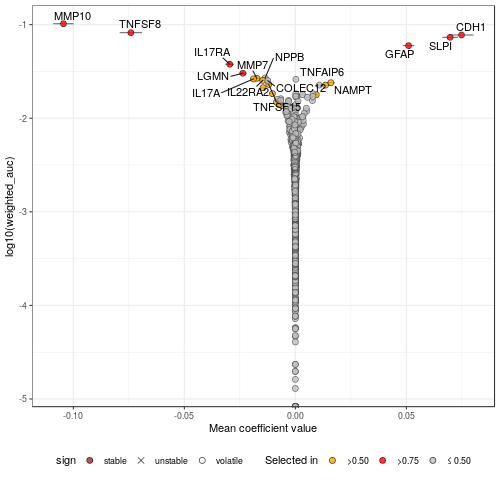

In [88]:
%%R -w 500 -i protein_contribs
coefficients_volcano_plot(
    protein_contribs,
    n=15, p_value='weighted_auc', neg=F
) + ylab('Mean coefficient value')

Models including large contributions from MMP10, CDH1 and SLP have the highest AUC in cross validation.

In [89]:
protein_contribs['p_value'] = protein_contribs['binomial_p']

In [90]:
protein_contribs.sort_values('binomial_p')

,mean,selected_in,positive_in,negative_in,volatile,...,binomial_p,binomial_FDR,gaussian_p,gaussian_FDR,weighted_auc
MMP10,-0.104463,1.00,0.00,1.00,0.0,...,0.132104,0.99995,9.702884e-08,0.000123,0.102297
PRKCG,-0.000347,0.08,0.00,0.08,0.0,...,0.478730,0.99995,6.219556e-04,0.198826,0.004313
OMD,0.000168,0.06,0.06,0.00,0.0,...,0.485552,0.99995,2.702856e-03,0.391347,0.002665
GFAP,0.051023,0.85,0.85,0.00,0.0,...,0.497396,0.99995,6.125049e-04,0.198826,0.059638
SERPINA1,0.002575,0.25,0.25,0.00,0.0,...,0.548195,0.99995,1.694157e-03,0.306884,0.010223
...,...,...,...,...,...,...,...,...,...,...,...
JAG1,-0.001333,0.18,0.00,0.18,0.0,...,0.999798,0.99995,9.281699e-01,0.963898,0.007260
MEPE,0.000043,0.02,0.02,0.00,0.0,...,0.999871,0.99995,6.655850e-01,0.944455,0.002089
VTA1,0.000011,0.01,0.01,0.00,0.0,...,0.999942,0.99995,6.324149e-01,0.944455,0.001108
LY96,-0.000206,0.05,0.00,0.05,0.0,...,0.999949,0.99995,7.696188e-01,0.944455,0.004114


#### Single scale cross-validation

And the problem persists in single scale CV...

In [91]:
single_scale = dict(multi_scale=False, test_size_min=0.25, test_size_max=0.25)

In [92]:
protein_lasso_ss = cross_validate(
    lasso_pipeline_protein,
    two_blocks_with_supervision(
        subset(raw_protein_matrix, full_cm_and_tmdr),
        full_cm_and_tmdr
    ),
    n=100,
    stratify=T,
    early_normalization=True,
    **single_scale
)

In [93]:
cv_null_tbm_single_scale = partial(
    null_distributions_over_cv, response=clinical.Meningitis, case_class='Tuberculosis',
    stratify=T,
    min_class_members=2,
    **single_scale
)

In [94]:
protein_lasso_null_distributions_single_scale = cv_null_tbm_single_scale(
    lasso_pipeline_protein,
    two_blocks_with_supervision(
        subset(raw_protein_matrix, full_cm_and_tmdr),
        full_cm_and_tmdr
    ),
    block='x',
    n=100,
    permutations=100,
    verbose=F,
    early_normalization=True
)

In [95]:
protein_lasso_ss.cross_validation.coefficients.x.add_permutation_significance(
    protein_lasso_null_distributions_single_scale.cross_validation.coefficients,
    n=25, decrease_n_by=5
)
protein_lasso_ss.cross_validation.contributions.x.add_permutation_significance(
    protein_lasso_null_distributions_single_scale.cross_validation.contributions,
    n=25, decrease_n_by=5
)

/home/krassowski/.pyenv/versions/3.7.2/envs/meningitis/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2159: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/home/krassowski/.pyenv/versions/3.7.2/envs/meningitis/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/krassowski/.pyenv/versions/3.7.2/envs/meningitis/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/home/krassowski/meningitis/code/helpers/p_values.py:133: UserWarning: A good GPD fit could not be reached, using ECDF estimate instead
  warn(f'A good GPD fit could not be reached, using ECDF estimate instead')
/home/krassowski/.pyenv/versions/3.7.2/envs/meningitis/lib/python3.7/site-packages/skgof/ecdfgof.py:81: RuntimeWarning: divide by zero encountere

In [96]:
protein_coeffs_ss = protein_lasso_ss.cross_validation.coefficients.x.data
protein_contribs_ss = protein_lasso_ss.cross_validation.contributions.x.data

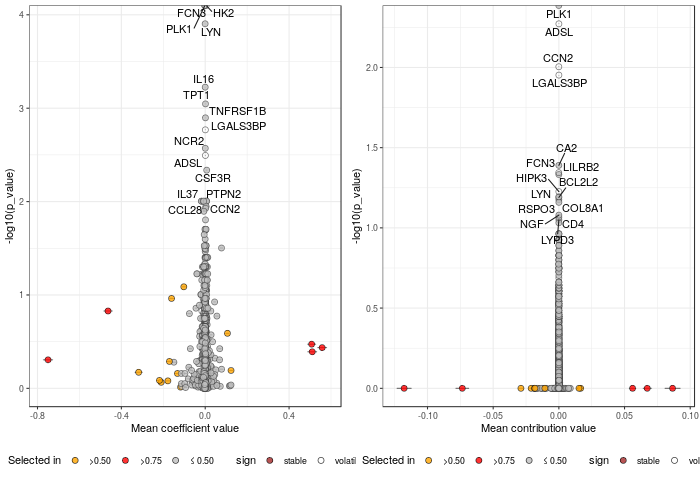

In [97]:
%%R -w 700 -i protein_coeffs_ss -i protein_contribs_ss
library(patchwork)
p1 = coefficients_volcano_plot(protein_coeffs_ss, n=15) + ylab('Mean coefficient value')
p2 = coefficients_volcano_plot(protein_contribs_ss, n=15) + ylab('Mean contribution value')
p1 + p2

#### Abundance

In [98]:
protein_contribs_subset = protein_lasso.cross_validation.contributions.x.select()

Adjusting non-zero ratio required to keep all significant coeffs
Selected 1143 coefficients different from zero in at least 0.01 repeats


In [99]:
groups = protein_full.index.map(clinical.Meningitis_with_tuberculosis_status)
protein_full.T.loc['PLA2G2A'].groupby(groups).mean()

Cryptococcal            -0.119399
Definite tuberculosis    0.824140
Healthy control         -0.259624
Possible tuberculosis    0.296479
Probable tuberculosis    0.265850
Viral                   -0.713927
Name: PLA2G2A, dtype: float64

In [100]:
protein_full.T.loc['MMP10'].groupby(groups).mean()

Cryptococcal             0.815169
Definite tuberculosis   -0.730617
Healthy control         -0.099009
Possible tuberculosis    0.203313
Probable tuberculosis   -0.709046
Viral                   -0.549625
Name: MMP10, dtype: float64

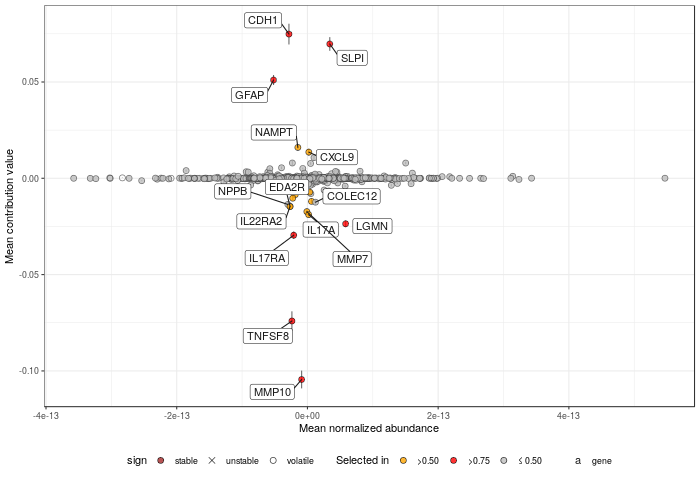

In [101]:
%%R -i protein_contribs -w 700
(
    mean_vs_coefficients(protein_contribs, n=15, fdr_threshold=NA)
    + ylab('Mean contribution value')
    + xlab('Mean normalized abundance')
)

#### Top coefficients

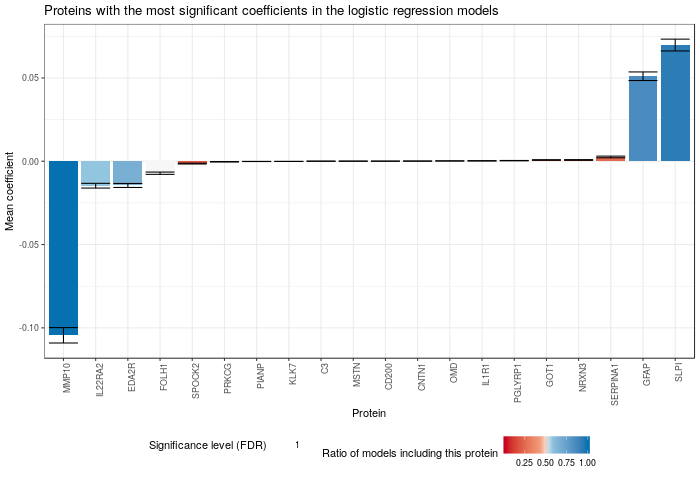

In [102]:
%%R -i protein_contribs -w 700
plot_most_significant(
    protein_contribs, n=20, label_margin=0.0,
    fill_name='Ratio of models including this protein',
    type='coefficient'
) + xlab('Protein') + ggtitle('Proteins with the most significant coefficients in the logistic regression models')

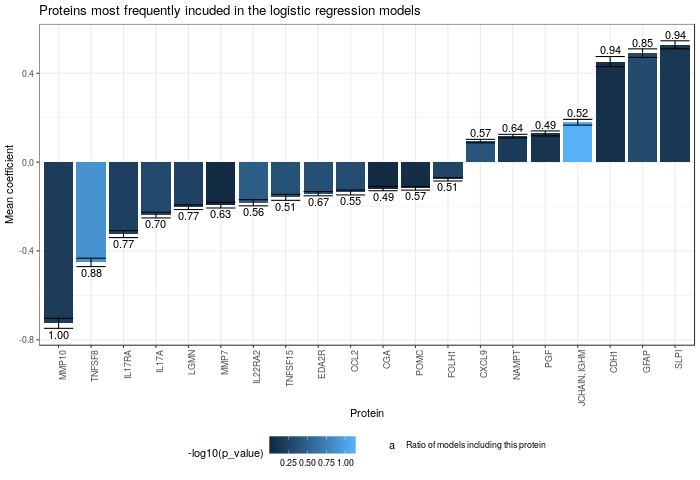

In [103]:
%%R -i protein_coeffs -w 700
plots_most_frequently_included(
    protein_coeffs, n=20, label_margin=0.01,
    label_name='Ratio of models including this protein',
    type='coefficient'
) + xlab('Protein') + ggtitle('Proteins most frequently incuded in the logistic regression models')

#### Top contributions

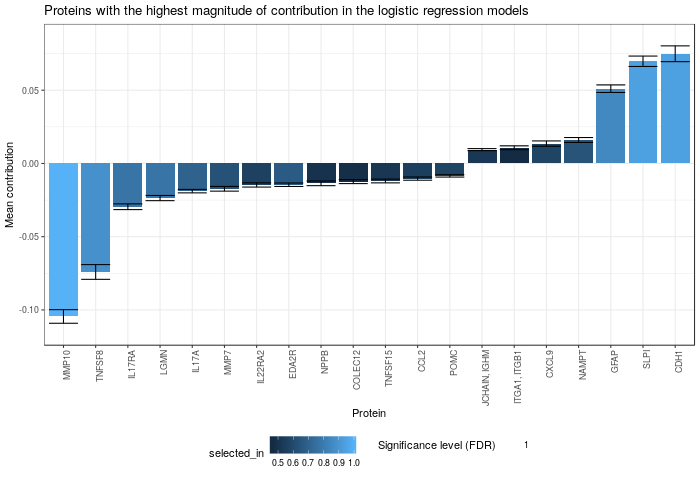

In [104]:
%%R -i protein_contribs -w 700
plot_highest_magnitutude(
    protein_contribs, n=20, label_margin=0.005,
    fill_name='Ratio of models including this protein',
) + xlab('Protein') + ggtitle('Proteins with the highest magnitude of contribution in the logistic regression models')

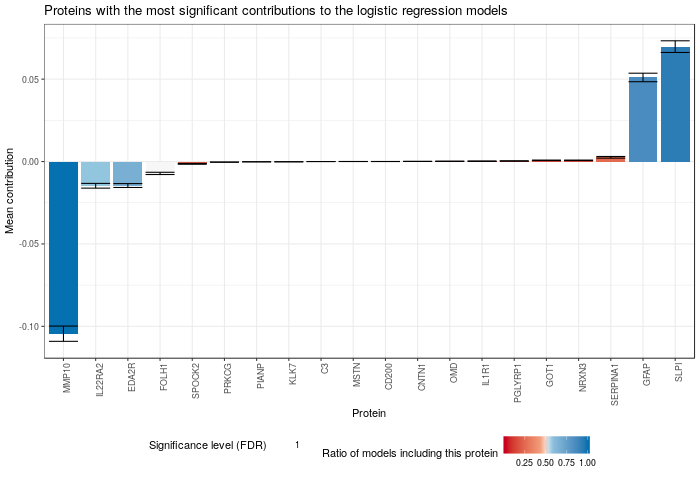

In [105]:
%%R -i protein_contribs -w 700
plot_most_significant(
    protein_contribs, n=20, label_margin=0.001,
    fill_name='Ratio of models including this protein'
) + xlab('Protein') + ggtitle('Proteins with the most significant contributions to the logistic regression models')

#### Cross-validation performance (is very high)

In [106]:
roc_auc = protein_lasso.cross_validation_results.roc_auc

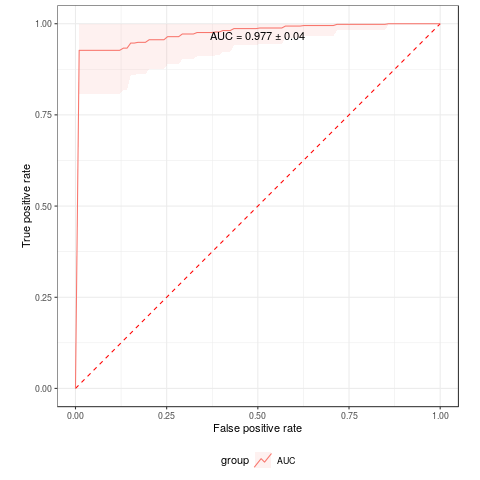

In [107]:
%%R -i roc_auc
plot_roc_auc(roc_auc, mean_auc=T)

### 1.2 Transcripts

Notes:
 - Pareto scaling/no scaling may improve RNA seq results, because it can "guide" the LASSO to select important variables

Again, only for diagnostic use:

In [108]:
rna_full = preprocess('rna', 7, RNA_OUTLIERS).fit_transform(raw_rna_matrix.T)

[1] "Retaining: 52.62%"


In [109]:
lasso_pipeline_rna = create_lasso_pipeline(
    'rna',
    smallest_group_n=7,
    subset=full_cm_and_tmdr,
    outliers=RNA_OUTLIERS,
    verbose=False
)

[1] "Retaining: 52.62%"


In [110]:
rna_lasso = cross_validate(
    lasso_pipeline_rna,
    two_blocks_with_supervision(
        subset(raw_rna_matrix, full_cm_and_tmdr, outliers=RNA_OUTLIERS),
        full_cm_and_tmdr
    ),
    n=100,
    verbose=F
)

OutliersFilter: filtering out 6 outliers


#### Abundance

In [111]:
rna_coeffs = rna_lasso.cross_validation.coefficients.x.data
rna_contribs = rna_lasso.cross_validation.contributions.x.data

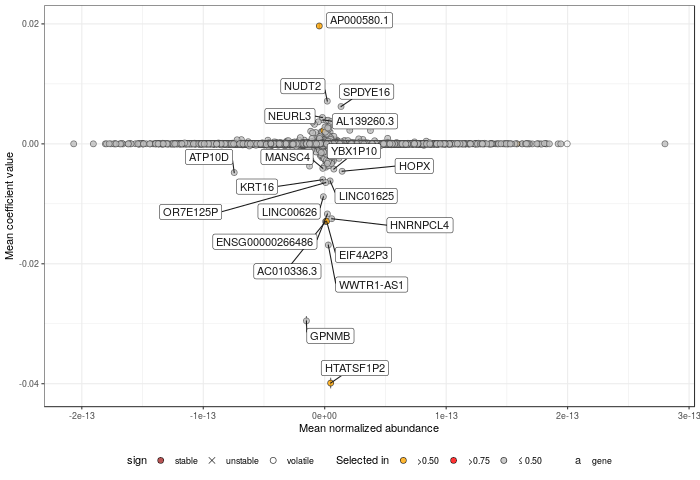

In [112]:
%%R -i rna_contribs -w 700
mean_vs_coefficients(rna_contribs, n=20, fdr_threshold=NA) + ylab('Mean coefficient value') + xlab('Mean normalized abundance')

#### Significance

HDI requires to remove the few non-expressed transcripts: 

In [113]:
rna_non_expressed_in_train = rna_lasso.training_dataset.x.sum() == 0
rna_lasso_train_zero_filtered = rna_lasso.training_dataset.x.loc[:, ~rna_non_expressed_in_train]

Filtering 15% of train data:

In [114]:
rna_non_expressed_in_train.sum() / len(rna_lasso_train_zero_filtered.columns)

0.1567938021454112

RNA dataset is still over 30 times bigger:

In [115]:
mul = lambda a: a[0] * a[1]
rna_size = mul(rna_lasso_train_zero_filtered.shape)
protein_size = mul(protein_lasso.training_dataset.x.shape)

rna_size / protein_size

31.505257134682783

However the computation would not end in 20 hours (on 6 cores, using stripped version), and as no indication of remianing running time is provied it was skipped:

In [117]:
# rna_lasso.cross_validation.contributions.x.add_hdi_significance(
#    rna_lasso_train_zero_filtered,
#    rna_lasso.training_dataset.binary_response,
#    family='binomial',
#    cores=6,
#    suppress_group_testing=True,
#    verbose=True
#)

In [ ]:
# %%R -i rna_contribs -w 700
# plots_most_frequently_included(
#     rna_contribs, n=20, label_margin=0.01,
#     label_name='Ratio of models including this transcript',
# ) + xlab('Transcript') + ggtitle('Transcripts most frequently incuded in the logistic regression models')

#### Features driving models with high AUC

In [118]:
rna_lasso.cross_validation.contributions.x.add_weighted_auc(rna_lasso.cross_validation_results.cv_auc)

12 null models detected
13989 genes not selected in any model detected


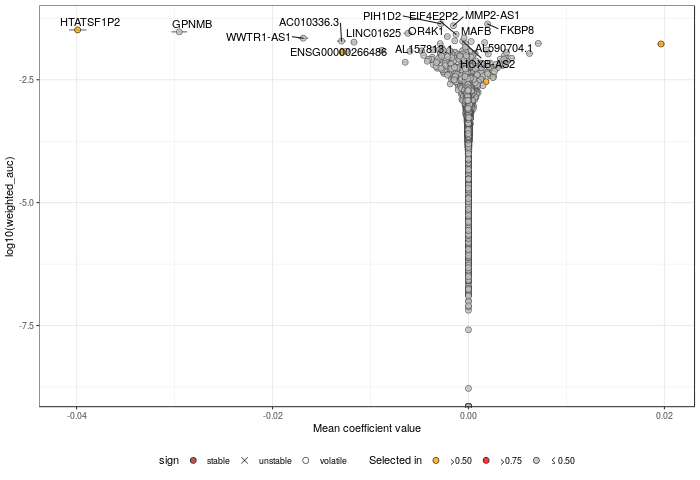

In [119]:
%%R -w 700 -i rna_contribs
coefficients_volcano_plot(
    rna_contribs,
    n=15, p_value='weighted_auc', neg=F
) + ylab('Mean coefficient value')

- AP000580.1 - ribosomal protein S20 (RPS20) pseudogene, RSF1 neighborhood
- ENSG00000266486 - FAM106CP

#### Cross-validation performance (is low)

In [120]:
roc_auc = rna_lasso.cross_validation_results.roc_auc

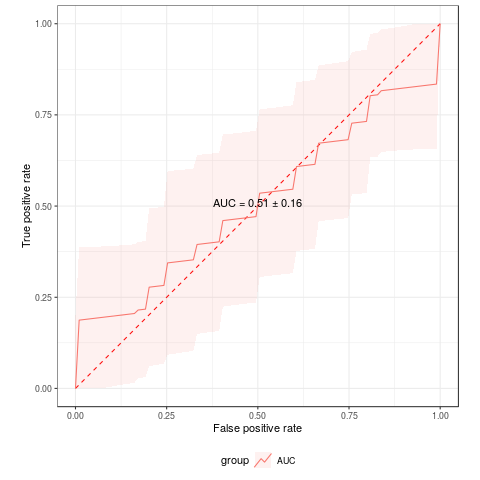

In [121]:
%%R -i roc_auc
plot_roc_auc(roc_auc, mean_auc=T)

#### Is this because of lack of the convergence ("too many variables"?)

In [122]:
shared_subset = protein_full.columns & rna_full.columns
rna_subset_lasso = cross_validate(
    lasso_pipeline_rna,
    two_blocks_with_supervision(
        subset(raw_rna_matrix.loc[shared_subset], full_cm_and_tmdr, outliers=RNA_OUTLIERS),
        full_cm_and_tmdr
    ),
    n=100,
    verbose=F
)

OutliersFilter: filtering out 6 outliers


In [123]:
roc_auc = rna_subset_lasso.cross_validation_results.roc_auc

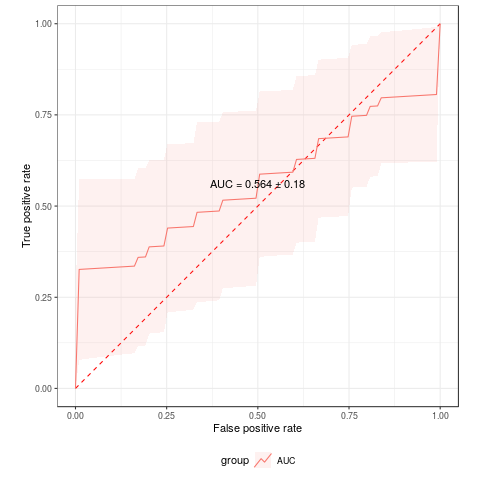

In [124]:
%%R -i roc_auc
plot_roc_auc(roc_auc, mean_auc=T)

## 2. Logistic LASSO with joint data only

In order not to contaminate our predictions with knowledge of the full dataset we strictly remove the data from outside of the subset:

In [125]:
patients_with_single_omic = Series(
    list(patients_union.difference(patients_with_both))
)

In [126]:
cm_and_tmdr_validation = patients_with_single_omic[
    patients_with_single_omic.str.contains('TMR|TMD|CM')
]

In [127]:
tms_validation = pd.concat([
    patients_union_series[patients_union_series.str.contains('TMS')],
    patients_with_single_omic[patients_with_single_omic.str.contains('CM')]
])

In [128]:
from machine_learning.data_classes import MultiBlockDataSet

tms_protein_dataset = MultiBlockDataSet(
    [*two_blocks_with_supervision(subset(raw_protein_matrix, tms_validation), tms_validation)],
    case_class='Tuberculosis',
    response=clinical.Meningitis
)
tms_rna_dataset = MultiBlockDataSet(
    [*two_blocks_with_supervision(subset(raw_rna_matrix, tms_validation, outliers=RNA_OUTLIERS), tms_validation)],
    case_class='Tuberculosis',
    response=clinical.Meningitis
)

OutliersFilter: filtering out 2 outliers


### 2.1 Proteins

In [129]:
lasso_pipeline_joint_protein = create_lasso_pipeline(
    'protein',
    smallest_group_n=7,
    subset=joint_cm_and_tmdr,
    outliers=None,
    verbose=False
)

[1] "Retaining: 99.92%"


Ideas:
- for O2-PLS - just pass the joint matrix to repeated cross validation and see what happens. This requires a simplified pipeline.
- for joint logistic: let's evaluate all the the random replicates on the patients with single omic! (training with everything, changing seed only OR also withholding some samples)

In [130]:
joint_protein_lasso = cross_validate(
    lasso_pipeline_joint_protein,
    two_blocks_with_supervision(
        subset(raw_protein_matrix, joint_cm_and_tmdr),
        joint_cm_and_tmdr
    ),
    test_data=two_blocks_with_supervision(
        subset(raw_protein_matrix, cm_and_tmdr_validation),
        cm_and_tmdr_validation
    ),
    n=100,
    verbose=F,
    stratify=T,
    early_normalization=False
)

In [131]:
tms_protein_result = joint_protein_lasso.validate(tms_protein_dataset)
tms_protein_result_sub = joint_protein_lasso.cross_validation.validate(tms_protein_dataset)

In [132]:
roc_auc = pd.concat([
    joint_protein_lasso.cross_validation_results.roc_auc.assign(group='CV train: TMD+TMR vs CM', models='Cross-Validation', set='Train: TMD+TMR vs CM'),
    joint_protein_lasso.sub_sampling_test_results.roc_auc.assign(group='CV test: TMD+TMR vs CM', models='Cross-Validation', set='Test: TMD+TMR vs CM'),
    tms_protein_result_sub.roc_auc.assign(group='CV test: TMS vs CM', models='Cross-Validation', set='Test: TMS vs CM'),
    tms_protein_result.roc_auc.assign(group='Full test: TMS vs CM', models='Full model', set='Test: TMS vs CM'),
    joint_protein_lasso.test_result.roc_auc.assign(group='Full test: TMD+TMR vs CM', models='Full model', set='Test: TMD+TMR vs CM')
])

 vs 0.7696666666666667



Attaching package: ‘grid’

The following object is masked from ‘package:imager’:

    depth



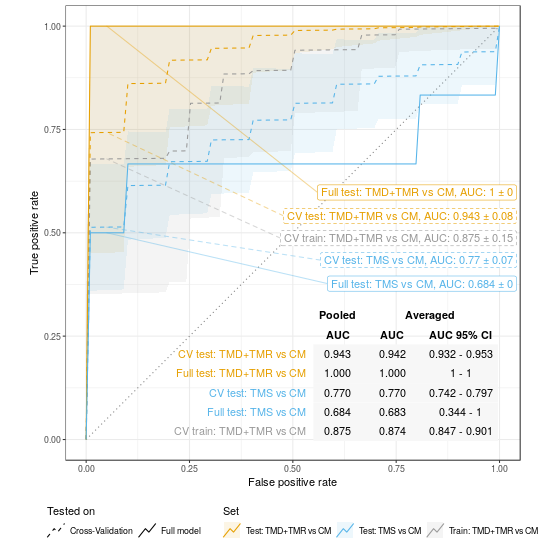

In [133]:
%%R -i roc_auc -w 550 -h 550
import::here(plot_roc_auc, add_linetype_to_ggrepel, .from='plots/machine_learning.R')
        
colors = c('Test: TMD+TMR vs CM'='#E69F00', 'Test: TMS vs CM'='#56B4E9', 'Train: TMD+TMR vs CM'='#999999')
p = (
    plot_roc_auc(
        roc_auc, annotate_lines=T, table=T,
        color='set', linetype='models',
        random_color='grey50', random_linetype=3,
        table_row_colors=colors, annotation_at=0.05,
        annotation_x=0.05, nudge_x=1,
        nudge_y=-1,
        direction='y',
        ylim=c(0.35, 0.65),
        table_xmin=0.45, table_xmax=0.75
    )
    + scale_color_manual(
        name='Set',
        values=colors
    )
    + scale_fill_manual(
        name='Set',
        values=colors
    )
    + scale_linetype_manual(
        name='Tested on',
        values=c('Cross-Validation'='dashed', 'Full model'='solid')
    )
    + guides(
        linetype=guide_legend(title.position='top'),
        fill=guide_legend(title.position='top'),
        color=guide_legend(title.position='top')
    )
    # + ggtitle()
)

line_types = c(2,1,2,1,2,2)
g = add_linetype_to_ggrepel(ggplotGrob(p), line_types, 'segment')
g = add_linetype_to_ggrepel(g, line_types, 'box')
p = grid.draw(g)

The ribbon highlights the distance of one standard deviation from the pooled AUC and is only drawn for the results based on CV models. The numbers given on the ROC curve labels are: pooled AUC +/- standard deviation.

Both tests sets were evaluated on all CV models to provide the error estimate.

TMD+TMR and CM use data of patients with single omic only.
TMS was composed of patients with single or both omics.

The use of the full model is unbiased, while the use of surrogate models is more informative (but pessimistic)

#### Features driving models with high AUC

In [134]:
joint_protein_lasso.cross_validation.contributions.x.add_weighted_auc(
    joint_protein_lasso.sub_sampling_test_results.cv_auc
)
joint_protein_contribs = joint_protein_lasso.cross_validation.contributions.x.data

1 null models detected
250 genes not selected in any model detected


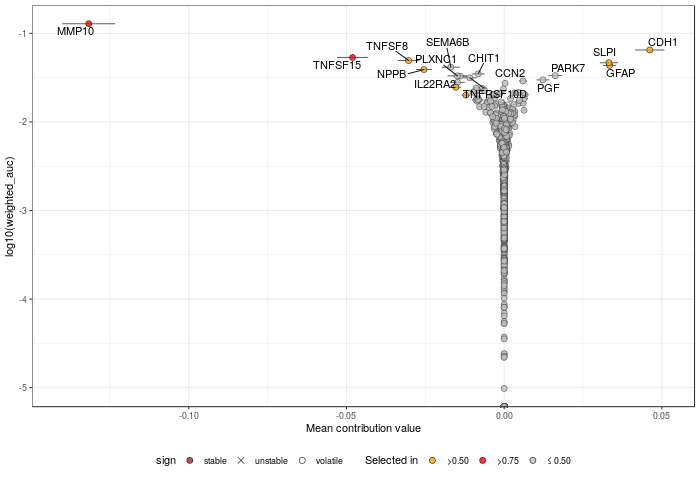

In [135]:
%%R -w 700 -i joint_protein_contribs
coefficients_volcano_plot(
    joint_protein_contribs,
    n=15, p_value='weighted_auc', neg=F
) + ylab('Mean contribution value')

### 2.2 Transcripts

In [136]:
lasso_pipeline_joint_rna = create_lasso_pipeline(
    'rna',
    smallest_group_n=7,
    subset=joint_cm_and_tmdr,
    outliers=RNA_OUTLIERS,
    verbose=False
)

[1] "Retaining: 52.62%"


In [137]:
joint_rna_lasso = cross_validate(
    lasso_pipeline_joint_rna, 
    two_blocks_with_supervision(
        subset(raw_rna_matrix, joint_cm_and_tmdr, outliers=RNA_OUTLIERS),
        joint_cm_and_tmdr
    ),
    test_data=two_blocks_with_supervision(
        subset(raw_rna_matrix, cm_and_tmdr_validation, outliers=RNA_OUTLIERS),
        cm_and_tmdr_validation
    ),
    n=100,
    verbose=F,
    stratify=T,
    early_normalization=True
)

OutliersFilter: filtering out 0 outliers
OutliersFilter: filtering out 6 outliers


In [138]:
tms_rna_result = joint_rna_lasso.validate(tms_rna_dataset)
tms_rna_result_sub = joint_rna_lasso.cross_validation.validate(tms_rna_dataset)

In [139]:
roc_auc_joint_rna = pd.concat([
    joint_rna_lasso.cross_validation_results.roc_auc.assign(group='CV train: TMD+TMR vs CM', models='Cross-Validation', set='Train: TMD+TMR vs CM'),
    joint_rna_lasso.sub_sampling_test_results.roc_auc.assign(group='CV test: TMD+TMR vs CM', models='Cross-Validation', set='Test: TMD+TMR vs CM'),
    tms_rna_result_sub.roc_auc.assign(group='CV test: TMS vs CM', models='Cross-Validation', set='Test: TMS vs CM'),
    tms_rna_result.roc_auc.assign(group='Full test: TMS vs CM', models='Full model', set='Test: TMS vs CM'),
    joint_rna_lasso.test_result.roc_auc.assign(group='Full test: TMD+TMR vs CM', models='Full model', set='Test: TMD+TMR vs CM')
])

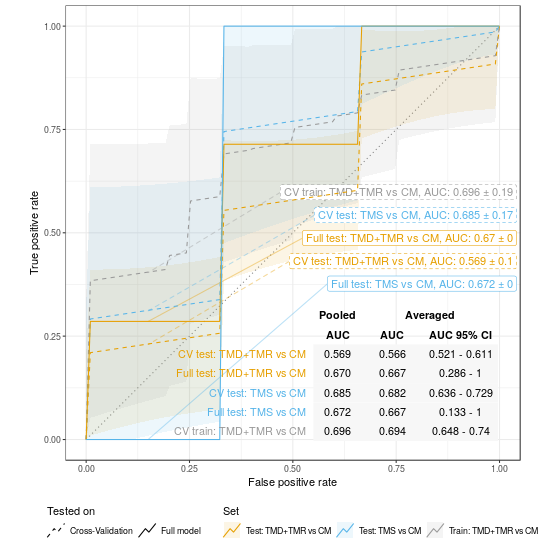

In [140]:
%%R -i roc_auc_joint_rna -w 550 -h 550
import::here(plot_roc_auc, add_linetype_to_ggrepel, .from='plots/machine_learning.R')
        
colors = c('Test: TMD+TMR vs CM'='#E69F00', 'Test: TMS vs CM'='#56B4E9', 'Train: TMD+TMR vs CM'='#999999')
p = (
    plot_roc_auc(
        roc_auc_joint_rna, annotate_lines=T, table=T,
        color='set', linetype='models',
        random_color='grey50', random_linetype=3,
        table_row_colors=colors, annotation_at=0.15,
        annotation_x=0.15, nudge_x=1,
        nudge_y=-1,
        direction='y',
        ylim=c(0.35, 0.65),
        table_xmin=0.45, table_xmax=0.75
    )
    + scale_color_manual(
        name='Set',
        values=colors
    )
    + scale_fill_manual(
        name='Set',
        values=colors
    )
    + scale_linetype_manual(
        name='Tested on',
        values=c('Cross-Validation'='dashed', 'Full model'='solid')
    )
    + guides(
        linetype=guide_legend(title.position='top'),
        fill=guide_legend(title.position='top'),
        color=guide_legend(title.position='top')
    )
    # + ggtitle()
)

line_types = c(2,1,2,1,2,2)
g = add_linetype_to_ggrepel(ggplotGrob(p), line_types, 'segment')
g = add_linetype_to_ggrepel(g, line_types, 'box')
grid.draw(g)

#### Features driving models with high AUC

In [141]:
joint_rna_lasso.cross_validation.contributions.x.add_weighted_auc(
    joint_rna_lasso.sub_sampling_test_results.cv_auc
)
joint_rna_contribs = joint_rna_lasso.cross_validation.contributions.x.data

15 null models detected
17613 genes not selected in any model detected


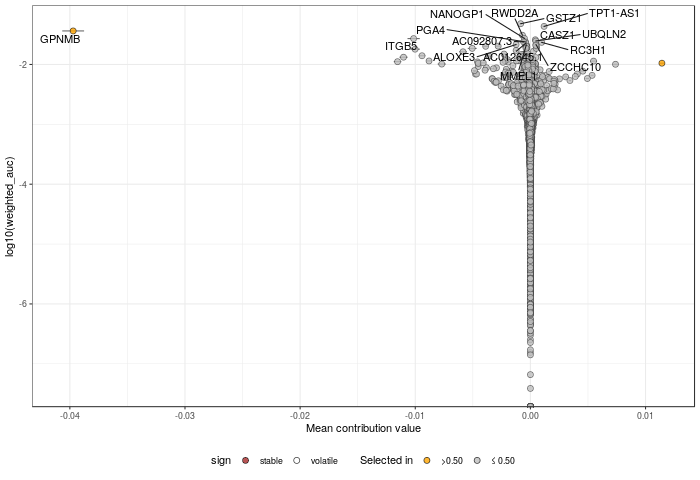

In [142]:
%%R -w 700 -i joint_rna_contribs
coefficients_volcano_plot(
    joint_rna_contribs,
    n=15, p_value='weighted_auc', neg=F
) + ylab('Mean contribution value')

### 2.3. Is the test set "easier"?

Could the better performance of the test set be attributed to the composition difference?
Is there more TMD patients in the TMD+TMR test set compared to train?

In [143]:
df = DataFrame(dict(
    train=joint_cm_and_tmdr.map(clinical.Meningitis_with_tuberculosis_status).value_counts(),
    test=cm_and_tmdr_validation.map(clinical.Meningitis_with_tuberculosis_status).value_counts()
))
df

,train,test
Cryptococcal,14,14
Definite tuberculosis,7,12
Probable tuberculosis,4,6


In [144]:
share = df / df.sum()
share

,train,test
Cryptococcal,0.56,0.4375
Definite tuberculosis,0.28,0.3750
Probable tuberculosis,0.16,0.1875


In [145]:
share.loc['Definite tuberculosis'] / share.loc['Probable tuberculosis']

train    1.75
test     2.00
dtype: float64

Yes, but only slightly.

## 3. Using protein scores extracted by O2PLS

In [146]:
def create_o2pls_pipeline(smallest_group_n, outliers, predict, max_components=2, subset=None, verbose=False, n_jobs=None):

    return TwoBlockPipeline(
        x=preprocess('rna', smallest_group_n, outliers),
        y=preprocess('protein', smallest_group_n, outliers),
        combine=(
            GridSearchCV(
                O2PLS(max_iterations=500, algorithm='nipals'),
                cv=3,# repeated?
                iid=True,
                scoring={
                    'average_cv_predictions': cv_scoring['average_cv_predictions']
                },
                refit='average_cv_predictions',
                param_grid=[{
                    # remained: the second is non inclusive
                    'joint_components': range(1, max_components),
                    'x_ortho_components': range(0, max_components),
                    'y_ortho_components': range(0, max_components)
                }],
                verbose=verbose,
                n_jobs=n_jobs
            )
        ),
        predict=predict
    )


def predict_protein_scores(pipeline, dataset, calculate='calculate_Y_scores_U_without_osc'):
    prediction = pipeline.call(
        calculate,
        pipeline.y.transform(dataset.y)
    )
    if len(prediction.columns) != 1:  # for more columns, more advanced technique needed
        print('warning: more latent components chosen!', len(prediction.columns))
    return -prediction[0]


o2pls_pipeline = create_o2pls_pipeline(
    smallest_group_n=7,
    outliers=RNA_OUTLIERS,
    verbose=0,
    max_components=2,
    predict=predict_protein_scores
)

[1] "Retaining: 52.62%"
[1] "Retaining: 99.92%"


In [147]:
def two_blocks_for_integration(rna, protein, patients, outliers, dummy_rna=False):
    b = subset(protein, patients, outliers=outliers)

    return [
        # for o2pls we only validate with protein data as we do not have enough paired observations
        b if dummy_rna else subset(rna, patients, outliers=outliers).loc[b.index],
        b
    ]

In [ ]:
tms_o2pls_protein_dataset = MultiBlockDataSet(
    [
        *two_blocks_for_integration(
            None, raw_protein_matrix,
            patients=tms_validation, outliers=RNA_OUTLIERS,
            dummy_rna=True
        )
    ],
    case_class='Tuberculosis',
    response=clinical.Meningitis
)

OutliersFilter: filtering out 1 outliers


In [ ]:
joint_o2pls = cross_validate(
    o2pls_pipeline,
    two_blocks_for_integration(
        raw_rna_matrix, raw_protein_matrix,
        patients=joint_cm_and_tmdr, outliers=RNA_OUTLIERS
    ),
    test_data=two_blocks_for_integration(
        None, raw_protein_matrix,
        patients=cm_and_tmdr_validation, outliers=RNA_OUTLIERS,
        dummy_rna=True
    ),
    n=100,
    verbose=F,
    stratify=T,
    coefficients={'x': 'W', 'y': 'C'},  # alternatives: _x_coefficients, _y_coefficients
    early_normalization=True
)

OutliersFilter: filtering out 0 outliers
OutliersFilter: filtering out 0 outliers
OutliersFilter: filtering out 3 outliers


In [ ]:
joint_o2pls.pipeline.combine.best_estimator_.calc_metrics()

,$R^2X$,$R^2Y$,$R^2X_{hat}$,$R^2Y_{hat}$,$R^2X_{YO}$,$R^2Y_{XO}$,$R^2X_{corr}$,$R^2Y_{corr}$
0,0.046915,0.176504,0.046915,0.176504,0.0,0.0,0.078022,0.293532


In [ ]:
joint_o2pls.pipeline.combine.best_estimator_.calc_metrics(
    X=joint_o2pls.pipeline.transformed_blocks['x'],
    Y=joint_o2pls.pipeline.transformed_blocks['y']
)

,$Q^2X_{hat}$,$Q^2Y_{hat}$,$\frac{Q^2X_{hat} + Q^2Y_{hat}}{2}$
0,0.046915,0.176504,0.11171


In [ ]:
tms_o2pls_result = joint_o2pls.validate(tms_o2pls_protein_dataset)
tms_o2pls_result_sub = joint_o2pls.cross_validation.validate(tms_o2pls_protein_dataset)

In [ ]:
roc_auc_o2pls = pd.concat([
    joint_o2pls.cross_validation_results.roc_auc.assign(group='CV train: TMD+TMR vs CM', models='Cross-Validation', set='Train: TMD+TMR vs CM'),
    joint_o2pls.sub_sampling_test_results.roc_auc.assign(group='CV test: TMD+TMR vs CM', models='Cross-Validation', set='Test: TMD+TMR vs CM'),
    tms_o2pls_result_sub.roc_auc.assign(group='CV test: TMS vs CM', models='Cross-Validation', set='Test: TMS vs CM'),
    tms_o2pls_result.roc_auc.assign(group='Full test: TMS vs CM', models='Full model', set='Test: TMS vs CM'),
    joint_o2pls.test_result.roc_auc.assign(group='Full test: TMD+TMR vs CM', models='Full model', set='Test: TMD+TMR vs CM')
])

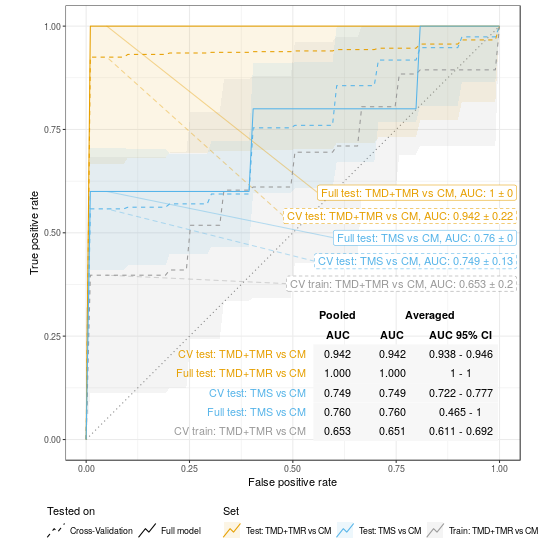

In [ ]:
%%R -i roc_auc_o2pls -w 550 -h 550
import::here(plot_roc_auc, add_linetype_to_ggrepel, .from='plots/machine_learning.R')
        
colors = c('Test: TMD+TMR vs CM'='#E69F00', 'Test: TMS vs CM'='#56B4E9', 'Train: TMD+TMR vs CM'='#999999')
p = (
    plot_roc_auc(
        roc_auc_o2pls, annotate_lines=T, table=T,
        color='set', linetype='models',
        random_color='grey50', random_linetype=3,
        table_row_colors=colors, annotation_at=0.05,
        annotation_x=0.05, nudge_x=1,
        nudge_y=-1,
        direction='y',
        ylim=c(0.35, 0.65),
        table_xmin=0.45, table_xmax=0.75
    )
    + scale_color_manual(
        name='Set',
        values=colors
    )
    + scale_fill_manual(
        name='Set',
        values=colors
    )
    + scale_linetype_manual(
        name='Tested on',
        values=c('Cross-Validation'='dashed', 'Full model'='solid')
    )
    + guides(
        linetype=guide_legend(title.position='top'),
        fill=guide_legend(title.position='top'),
        color=guide_legend(title.position='top')
    )
    # + ggtitle()
)

line_types = c(2,1,2,1,2,2)
g = add_linetype_to_ggrepel(ggplotGrob(p), line_types, 'segment')
g = add_linetype_to_ggrepel(g, line_types, 'box')
p = grid.draw(g)

In [ ]:
grid_results = add_grid_metadata(format_grid_results(
    joint_o2pls.cross_validation.estimators[0].combine,
    joint_o2pls.cross_validation.estimators[0].transformed_blocks['x']
))

In [ ]:
grid_results.head()

,param_joint_components,param_x_ortho_components,param_y_ortho_components,variable,value,...,symbol,joint_mean,mean,std,ortho_gain_percent
0,1.0,0.0,0.0,split0_test_average_cv_predictions,-0.108983,...,$\frac{Q^2X_{hat} + Q^2Y_{hat}}{2}$,-0.099852,-0.074031,0.082760,25.859502
1,1.0,0.0,1.0,split0_test_average_cv_predictions,-0.153090,...,$\frac{Q^2X_{hat} + Q^2Y_{hat}}{2}$,-0.099852,-0.131885,0.079840,-32.079638
2,1.0,1.0,0.0,split0_test_average_cv_predictions,-0.161745,...,$\frac{Q^2X_{hat} + Q^2Y_{hat}}{2}$,-0.099852,-0.093792,0.102389,6.069331
3,1.0,1.0,1.0,split0_test_average_cv_predictions,-0.171337,...,$\frac{Q^2X_{hat} + Q^2Y_{hat}}{2}$,-0.099852,-0.099702,0.104101,0.150805
4,1.0,0.0,0.0,split1_test_average_cv_predictions,0.020471,...,$\frac{Q^2X_{hat} + Q^2Y_{hat}}{2}$,-0.099852,-0.074031,0.082760,25.859502


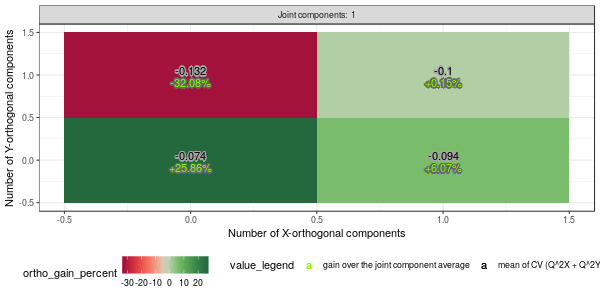

In [ ]:
%%R -w 600 -h 300 -i grid_results
grid_orthogonal_components_plot(grid_results)

## Scratchpad and ideas for future research

- Pathways enrichment might be more meaningful with Ridge regularization
- Random forest would be another very simple but potentially useful classifier
- Group LASSO may solve the issue of multi-collinearity, there is an sklearn-API for it: https://pypi.org/project/group-lasso/